<a href="https://colab.research.google.com/github/kicysh/final_task_of_world_model_lecture_2021/blob/main/docs/reproduction_paper_fig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# command line
以下のpipセクション終了後に必ず**ランタイムの再起動**を行うこと

In [1]:
!pip install scanpy scikit-misc

# install ldvae
!git clone https://github.com/kicysh/final_task_of_world_model_lecture_2021/
!pip install final_task_of_world_model_lecture_2021/package/. --use-feature=in-tree-build

     |████████████████████████████████| 2.0 MB 5.1 MB/s 
     |████████████████████████████████| 8.8 MB 38.3 MB/s 
     |████████████████████████████████| 96 kB 4.5 MB/s 
     |████████████████████████████████| 11.2 MB 34.5 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 
     |████████████████████████████████| 900 kB 40.9 MB/s 
     |████████████████████████████████| 1.1 MB 40.9 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=8aa9b4e0b66515ffe06870725e9ef24a41a835487d4d5512d46f3f17e7a190c3
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=1d9805dcb06de117e36ad639a1b7e6fdd6fe3dd2a0e7029fa6c6a09bec512ea1
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
  Created 

Cloning into 'final_task_of_world_model_lecture_2021'...
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (227/227), done.
remote: Compressing objects: 100% (221/221), done.
remote: Total 227 (delta 42), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (227/227), 25.98 MiB | 8.64 MiB/s, done.
Resolving deltas: 100% (42/42), done.
Processing ./final_task_of_world_model_lecture_2021/package
  Created wheel for LDVAE: filename=LDVAE-0.1.0-py3-none-any.whl size=3274 sha256=bf84ee8a5ea145621274c9da499edb1803a9e4a4b73baa6ff187df647f944202
  Stored in directory: /tmp/pip-ephem-wheel-cache-g9fvcyyo/wheels/e2/2f/44/da18d64c7ac8950bd4f266d145db33398678d80aff1a4f488f
Successfully built LDVAE


In [2]:
!mkdir data figures intermediate
!gsutil cp gs://h5ad/2019-02-Pijuan-Sala-et-al-Nature/pijuan_sala_atlas.h5ad /content/data


Copying gs://h5ad/2019-02-Pijuan-Sala-et-al-Nature/pijuan_sala_atlas.h5ad...
/ [1 files][  1.0 GiB/  1.0 GiB]   47.7 MiB/s                                   
Operation completed over 1 objects/1.0 GiB.                                      


In [3]:
!pip list

Package                       Version
----------------------------- ---------------------
absl-py                       1.0.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.2.0
anndata                       0.8.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.4
branca                        0.4.2
bs4   

# setting


In [1]:
import ldvae

import numpy as np
import pandas as pd

import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import logsumexp
from torch.distributions import Normal, kl_divergence

import matplotlib.pyplot as plt

import scanpy as sc


In [2]:
# global
USE_CUDA = True

# model params
SETTING_HIDDEN_DIMS = (128,)
SETTING_LATENT_DIM = 20
SETTING_USE_NORM = True

SETTING_BATCH_SIZE = 1024

SETTING_N_TOP_GENES = 1000

SETTING_TRAIN_RATE = 0.8
SETTING_VAL_RATE = 0.2

DATA_PATH = '/content/data/pijuan_sala_atlas.h5ad'
W_CSV_PATH = '/content/intermediate/w.csv'
Z_CSV_PATH = '/content/intermediate/z.csv'

RANDOM_SEED = 42

In [3]:
# 再現性のため
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

GENERATOR = torch.Generator()
GENERATOR.manual_seed(RANDOM_SEED)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# data

## read data

In [4]:
adata = sc.read_h5ad(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 139331 × 29452
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster'
    var: 'gene_name'

## 前処理

In [5]:
idx = adata.obs.query('not doublet').index
adata = adata[idx]
sc.pp.highly_variable_genes(adata,n_top_genes=SETTING_N_TOP_GENES ,flavor='seurat_v3')
print(adata)


/usr/local/lib/python3.7/dist-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


AnnData object with n_obs × n_vars = 125775 × 29452
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'


In [6]:
gene_index = adata.var[adata.var['highly_variable']].index
adata_df = adata.to_df()[gene_index]


## create dataset

In [7]:
class GenesDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 adata: np.array, 
                 transform=None, 
                 target_transform=None):
        self.data = adata
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getattr__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        if self.transform:
            data = self.transform(data)
        return data

## create dataloader

In [8]:
# dataloder
dataset = GenesDataset(adata_df.values)

n_samples = len(dataset) 
train_size = int(n_samples* SETTING_TRAIN_RATE)
val_size = int(n_samples * SETTING_VAL_RATE)
test_size = n_samples - train_size - val_size 

dataset_train ,dataset_valid, dataset_test = \
        torch.utils.data.random_split(dataset,
                                      [train_size, val_size,test_size],
                                      generator=GENERATOR)

dataloader_all = torch.utils.data.DataLoader(
    dataset,
    batch_size=SETTING_BATCH_SIZE,
    shuffle=False,
)

dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=SETTING_BATCH_SIZE,
    shuffle=True,
    num_workers=4, 
    pin_memory=True, 
    worker_init_fn=seed_worker, 
    generator=GENERATOR
)

dataloader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=SETTING_BATCH_SIZE,
    shuffle=True,
    #generator=GENERATOR.manual_seed(RANDOM_SEED)
)


# model

## define model

In [9]:
model = ldvae.LDVAE(genes_cnt = len(adata_df.columns),
                    hidden_dims=SETTING_HIDDEN_DIMS,
                    latent_dim = SETTING_LATENT_DIM)
model.set_local_l_mean_and_var(adata_df.values)
model

LDVAE(
  (encoder_z): Sequential(
    (0): Linear(in_features=1000, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (encoder_z_mean): Linear(in_features=128, out_features=20, bias=True)
  (encoder_z_var): Linear(in_features=128, out_features=20, bias=True)
  (encoder_l): Sequential(
    (0): Linear(in_features=1000, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (encoder_l_mean): Linear(in_features=128, out_features=1, bias=True)
  (encoder_l_var): Linear(in_features=128, out_features=1, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=1000, bias=False)
    (1): BatchNorm1d(1000, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
)

## train

In [10]:
n_epochs  = 100
optimizer = optim.Adam(model.parameters(), lr=7e-3)

device = 'cuda'  if USE_CUDA else 'cpu'
model.to(device)

for epoch in range(n_epochs):
    losses = []

    model.train()
    for x in dataloader_train:
        x = x.to(device)

        #model.zero_grad()
        optimizer.zero_grad()
        # forawrd and loss
        reconst, kl_l ,kl_z = model.loss(x)
        loss = torch.mean(-reconst+kl_l +kl_z)

        nn.utils.clip_grad_norm_(model.parameters(), 0.25)
        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())

    losses_val1 = []
    losses_val2 = []
    losses_val3 = []

    model.eval()
    for x in dataloader_valid:

        x = x.to(device)
        reconst, kl_l ,kl_z = model.loss(x)

        losses_val1.append(torch.mean(-reconst).cpu().detach().numpy())
        losses_val2.append(torch.mean(kl_l).cpu().detach().numpy())
        losses_val3.append(torch.mean(kl_z).cpu().detach().numpy())

    print('EPOCH: %d    Train Loss: %lf    Valid rec: %lf    Valid kl_l: %lf    Valid kl_z: %lf' %
            (epoch+1, np.average(losses),np.average(losses_val1),np.average(losses_val2),np.average(losses_val3)))


EPOCH: 1    Train Loss: 1698.130493    Valid rec: 1125.620361    Valid kl_l: 5.421280    Valid kl_z: 14.945195
EPOCH: 2    Train Loss: 798.988464    Valid rec: 884.652344    Valid kl_l: 1.825883    Valid kl_z: 12.276510
EPOCH: 3    Train Loss: 699.895447    Valid rec: 801.270569    Valid kl_l: 1.409926    Valid kl_z: 12.058089
EPOCH: 4    Train Loss: 647.530273    Valid rec: 739.900696    Valid kl_l: 1.295012    Valid kl_z: 11.923763
EPOCH: 5    Train Loss: 620.390991    Valid rec: 693.465332    Valid kl_l: 1.830660    Valid kl_z: 23.367788
EPOCH: 6    Train Loss: 623.741882    Valid rec: 640.058411    Valid kl_l: 1.509092    Valid kl_z: 14.901388
EPOCH: 7    Train Loss: 595.312256    Valid rec: 592.304077    Valid kl_l: 1.356214    Valid kl_z: 14.877233
EPOCH: 8    Train Loss: 577.934814    Valid rec: 571.319763    Valid kl_l: 1.273447    Valid kl_z: 13.162880
EPOCH: 9    Train Loss: 565.862854    Valid rec: 546.777771    Valid kl_l: 1.161833    Valid kl_z: 13.060193
EPOCH: 10    Trai

# output intermediate files

## output weight

In [11]:
# w
import pandas as pd

_w = model.decoder[0].weight
bn = model.decoder[1]
sigma = torch.sqrt(bn.running_var + bn.eps)
gamma = bn.weight
b = gamma / sigma
bI = torch.diag(b)
loadings = torch.matmul(bI, _w)
loadings = loadings.detach().cpu().numpy()

W = pd.DataFrame(loadings, index=gene_index)
W.to_csv(W_CSV_PATH)


## output the latent variables (z)

In [12]:
# z
latent_array  = None
model.eval()
for x in dataloader_all:
    x = x.to(device)
    _z,_,_ = model(x)
    z_mean,_,_ = _z
    z_mean = z_mean.cpu().detach().numpy()
    if latent_array is None:
        latent_array = z_mean
    else:
        latent_array = np.concatenate([latent_array, z_mean])
pd.DataFrame(latent_array,index=adata_df.index).to_csv(Z_CSV_PATH)

# output figures

In [13]:
%pylab inline
%config InlineBackend.figure_format ='retina'

#import time

import anndata
import matplotlib.colors as mcolors

import plotnine as p

from matplotlib.patches import Ellipse
from scipy import stats
import matplotlib.cm as cm

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['gamma', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
w_df = pd.read_csv(W_CSV_PATH, index_col=0)
z_df = pd.read_csv(Z_CSV_PATH, index_col=0)

w_df = w_df.add_prefix('w')
z_df = z_df.add_prefix('z')

print('w_df====================')
print(w_df.head())
print('z_df====================')
print(z_df.head())

w_df====================
                          w0        w1        w2        w3        w4  \
index                                                                  
ENSMUSG00000025902 -0.184393 -1.047395 -0.402566 -0.879202  0.846103   
ENSMUSG00000025927  0.202000 -0.449858 -0.001836  1.166815  0.182340   
ENSMUSG00000026124 -0.189986 -1.687252 -0.213244  0.231604 -0.047182   
ENSMUSG00000026043 -0.323745 -1.589945 -1.016268  1.797427  0.264886   
ENSMUSG00000045954  0.058570 -1.586743  0.211868  1.305900 -0.618946   

                          w5        w6        w7        w8        w9  \
index                                                                  
ENSMUSG00000025902 -0.964658 -0.483782  0.747425 -1.373592 -0.494838   
ENSMUSG00000025927  1.795483 -0.258752 -1.161863 -0.090996  1.384169   
ENSMUSG00000026124 -1.273472 -0.194375  1.231013  0.703115 -0.235573   
ENSMUSG00000026043  0.623665  0.273306 -1.122483  0.180980  0.705222   
ENSMUSG00000045954  0.387467  0.174195

In [15]:
def Z_covariance(Z):
    """
    return matrix and explained variance

    params
    -------
    Z: np.array

    return
    ------
    ZTZ: np.array
    variance_explained: np.array
    """
    #Zcentered = Z - Z.mean(0)
    Zscaled = Z / Z.std(0)
    ZTZ = np.cov(Zscaled.T)
    
    eigen_values, _ = np.linalg.eig(ZTZ)
    singular_values = np.sqrt(eigen_values)
    variance_explained = singular_values / singular_values.sum()

    return ZTZ, variance_explained

In [16]:
def make_kde(x1, x2):
    """
    kernel density estimation ?
    """
    dx1 = (x1.max() - x1.min()) / 10
    dx2 = (x2.max() - x2.min()) / 10

    x1min = x1.min() - dx1
    x2min = x2.min() - dx2
    x1max = x1.max() + dx1
    x2max = x2.max() + dx2

    xx1, xx2 = np.mgrid[x1min:x1max:100j, x2min:x2max:100j]

    positions = np.vstack([xx1.ravel(), xx2.ravel()])
    values = np.vstack([x1, x2])

    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx1.shape)
    
    return xx1, xx2, f


In [17]:
# descending order by explained variance
_, variance_explained = Z_covariance(z_df)
idx = np.argsort(variance_explained)[::-1]

Z_df_ordered = pd.DataFrame(z_df.values[:, idx]).add_prefix('z')
Z_df_ordered.index = z_df.index
metadata = adata.obs.loc[Z_df_ordered.index].join(Z_df_ordered)

W_df_ordered = pd.DataFrame(w_df.values[:, idx]).add_prefix('w')
W_df_ordered.index = w_df.index
W_df_ordered = adata.var.loc[W_df_ordered.index].join(W_df_ordered)
vardata = W_df_ordered


In [18]:
def create_fig_0(#Z_df_ordered: pd.DataFrame,
                 #W_df_ordered: pd.DataFrame,
                 num_x: int,
                 num_y: int,
                 #metadata: anndata,
                 #vardata: anndata,
                 use_save: bool= True,
                 save_file_name: str='fig',
                 use_close: bool=False,
                 figsize:tuple=(7, 12 / 5)):
    '''
    create figure_1(c). 
    
    params
    -------
    num_x: int
        axis_x 
    num_y: int
        axis_y
    use_save: bool, default True
        set use_save to True if you want to save a figure.
    save_file_name: str, default 'fig'
        save figures/{save_file_name}_{num_x}_{num_y}.pdf if you set use_save to True.
    use_close:bool, default False
        set use_close to True if execute plt.close().
        plt.close() don't show a figure in ipynp.
    figsize: tuple, default (7, 12 / 5)

    '''
    # setting =======================
    num_x = str(num_x)
    axis_x_view_name = '_{'+num_x+'}'
    num_y = str(num_y)
    axis_y_view_name = '_{'+num_y+'}'

    plt.figure(figsize=figsize)

    # left fig =====================
    plt.subplot(1, 2, 1)

    # left hist fig
    plt.hist2d(
        Z_df_ordered['z'+num_x], 
        Z_df_ordered['z'+num_y],
        bins=256,
        norm=mcolors.PowerNorm(0.25),
        cmap=cm.gray_r,
        rasterized=True
    )

    ax = plt.gca()

    color_maps = [cm.Reds_r, cm.Blues_r, cm.Greens_r]
    cell_types = ['Erythroid3', 'ExE endoderm', 'Epiblast']
    for color, ctype in zip(color_maps, cell_types):
        X = metadata.query('celltype == @ctype')[['z'+num_x, 'z'+num_y]]
        xx1, xx2, f = make_kde(X['z'+num_x], X['z'+num_y])
        cset = ax.contour(
            xx1,
            xx2,
            f,
            levels=6,
            cmap=color,
            linewidths=1.
        )

    # left fig axis labels
    plt.axis('equal')
    idx = np.argsort(variance_explained)[::-1]
    plt.xlabel(f'$Z{axis_x_view_name}$ ' + \
               f'({variance_explained[idx][int(num_x)]:.1%} variance)')
    plt.ylabel(f'$Z{axis_y_view_name}$ ' + \
               f'({variance_explained[idx][int(num_y)]:.1%} variance)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # right figure ========================
    plt.subplot(1, 2, 2)
    plt.scatter(
        W_df_ordered['w'+num_x], 
        W_df_ordered['w'+num_y],
        c='lightgrey',
        rasterized=True
    )

    color_genes_set = [['r',['Hbb-bs', 'Hbb-bt', 'Hba-a2']],
                       ['g',['Pou5f1', 'Tdgf1', 'Snrpn']],
                       ['b',['Ctsh', 'Amn', 'Apoa4']]]

    for color,genes in color_genes_set:
        for gene in genes:
            x_, y_ = vardata.query('gene_name == @gene')[['w'+num_x, 'w'+num_y]].values[0]
            plt.arrow(0, 0, x_, y_, length_includes_head=True, color=color)
            r = 1+0.5/(x_**2+y_**2)**0.5
            plt.text(x_*r,y_*r, gene, color=color)


    plt.xlim(left=-3, right=3)
    plt.ylim(bottom=-3, top=3)

    plt.xlabel(f'$W{axis_x_view_name}$')
    plt.ylabel(f'$W{axis_y_view_name}$')

    ax = plt.gca()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if use_save:
        plt.savefig(f'figures/{save_file_name}_{num_x}_{num_y}.pdf', bbox_inches='tight', dpi=400)
    if use_close:
        plt.close()

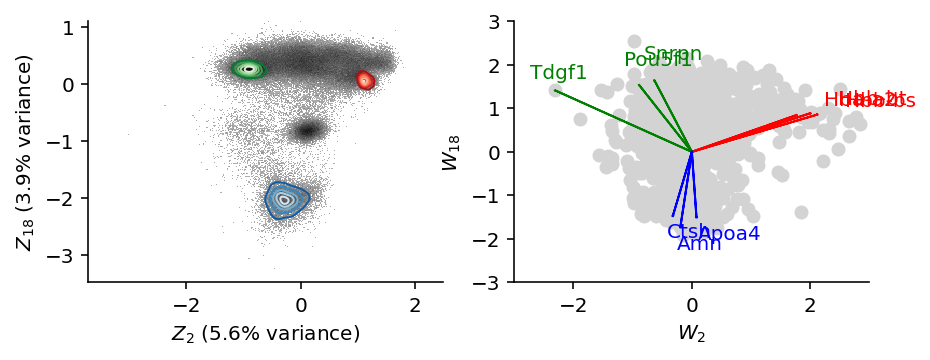

In [21]:
create_fig_0(num_x =2,num_y =18)

['Tmem114', 'Zic1', 'Elf5', 'Gm9', 'Tacstd2', 'Rhox1', 'Wnt6', 'Duoxa2']
Categories (29411, object): ['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik', ...,
                             'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']
['Hoxb5os', 'Hoxaas3', 'Mixl1', 'Tdgf1', 'Hoxb9', 'Cdx4', 'Cdx1', 'Mesp1']
Categories (29411, object): ['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik', ...,
                             'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']
['Clec1b', 'Emcn', 'Gimap6', 'Pf4', 'AC113508.1', 'Cldn5', 'Ctla2a', 'Gpr182']
Categories (29411, object): ['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik', ...,
                             'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']
['Nme9', 'Hesx1', 'Six3', 'Foxd4', 'Tekt4', 'Fezf1', '1700001C02Rik', '1700012B09Rik']
Categories (29411, object): ['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik', ...,
                             'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6'

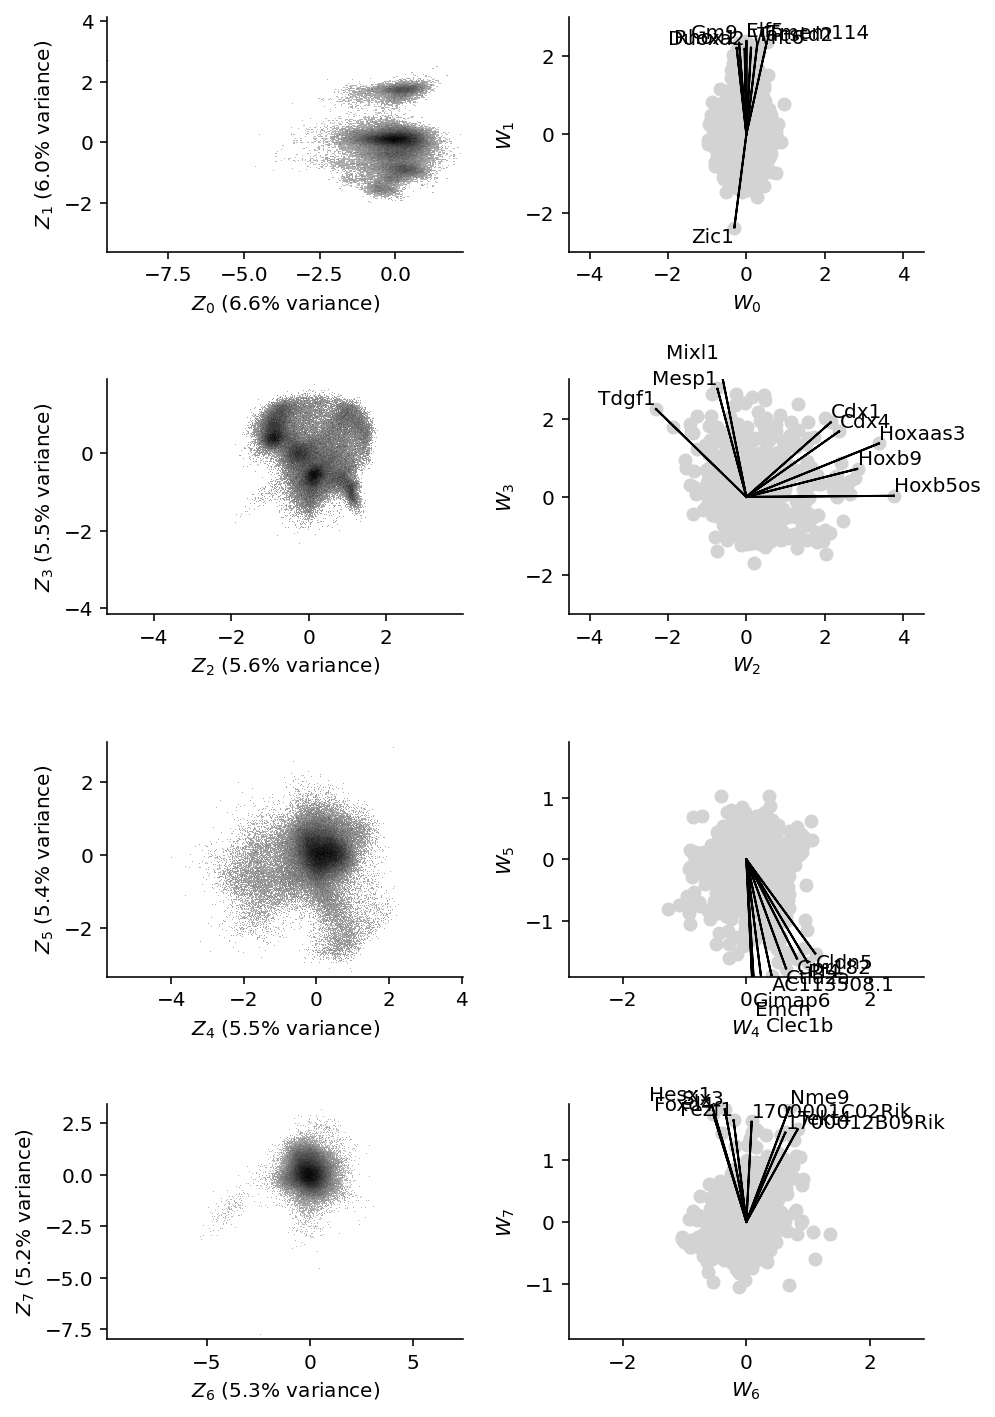

In [20]:
plt.figure(figsize=(7, 12)) 
for i in range(4):
    
    # -- Z plot --
    
    plt.subplot(5, 2, 2 * i + 1)
    
    plt.hist2d(
        Z_df_ordered[f'z{2 * i}'], Z_df_ordered[f'z{2 * i + 1}'],
        bins=256,
        norm=mcolors.PowerNorm(0.25),
        cmap=cm.gray_r,
        rasterized=True
    )
    plt.axis('equal');
    idx = np.argsort(variance_explained)[::-1]
    plt.xlabel(f'$Z_{2 * i}$ ({variance_explained[idx][2 * i]:.1%} variance)')
    plt.ylabel(f'$Z_{2 * i + 1}$ ({variance_explained[idx][2 * i + 1]:.1%} variance)')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # -- W plot --
    
    plt.subplot(5, 2, 2 * i + 2)
    
    w_columns = [f'w{2 * i}', f'w{2 * i + 1}']
    
    plt.scatter(
        W_df_ordered[w_columns[0]], W_df_ordered[w_columns[1]],
        c='lightgrey',
        rasterized=True
    )
    plt.axis('equal');
    plt.xlabel(f'$W_{2 * i}$')
    plt.ylabel(f'$W_{2 * i + 1}$')
    
    tmp_ = W_df_ordered.copy()
    tmp_['lnth'] = np.linalg.norm(tmp_[w_columns], axis=1)
    
    ggg = (
        tmp_
        .sort_values('lnth', ascending=False)
        .head(8)[['gene_name', 'lnth', *w_columns]]
    )
    print(ggg['gene_name'].values)
    
    texts = []
    arrows = []
    for g, r in ggg.iterrows():
        x_, y_ = r[w_columns[0]], r[w_columns[1]]
        
        ha = 'right'
        if x_ > 0:
            ha = 'left'
            
        va = 'top'
        if y_ > 0:
            va = 'bottom'
            
        arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True))
        
        xs, ys = 0, 0
        
        texts.append(plt.text(x_ + xs, y_ + ys, r.gene_name, ha=ha, va=va))

    plt.xlim(left=-3, right=3)
    plt.ylim(bottom=-3, top=3)
        
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.tight_layout()
plt.savefig('figures/linear_pij_results.pdf', bbox_inches='tight', dpi=400)

# EXTRA

In [21]:
print('相関係数 ===================================')
for ctype in np.unique(metadata['celltype']):
    z_corrs = Z_df_ordered.corrwith((metadata['celltype'] == ctype))
    top_factors = z_corrs.map(np.abs).sort_values(ascending=False).head(3)
    print([f'{z.rjust(3)}: {z_corrs[z]:+.2f}' for z in top_factors.index], ctype)

相関係数 ===================================
['z14: +0.22', 'z19: -0.21', ' z4: +0.21'] Allantois
[' z4: -0.19', ' z2: -0.15', 'z16: -0.13'] Anterior Primitive Streak
[' z5: -0.18', 'z12: -0.14', 'z11: -0.11'] Blood progenitors 1
['z12: -0.29', 'z11: -0.25', ' z5: -0.21'] Blood progenitors 2
['z16: -0.42', ' z9: -0.21', ' z0: -0.19'] Cardiomyocytes
[' z3: +0.15', ' z2: +0.13', ' z9: -0.08'] Caudal Mesoderm
[' z3: +0.21', 'z17: -0.15', ' z2: +0.14'] Caudal epiblast
['z17: -0.12', 'z11: +0.11', 'z14: -0.07'] Caudal neurectoderm
[' z4: -0.19', 'z14: +0.18', ' z7: +0.14'] Def. endoderm
[' z5: -0.37', ' z7: -0.25', ' z3: -0.16'] Endothelium
[' z2: -0.48', 'z19: +0.42', 'z11: +0.33'] Epiblast
['z11: -0.27', ' z1: -0.24', 'z19: +0.21'] Erythroid1
['z11: -0.18', ' z1: -0.17', 'z19: +0.17'] Erythroid2
[' z1: -0.32', 'z11: -0.31', 'z19: +0.30'] Erythroid3
[' z1: +0.75', 'z18: -0.35', 'z19: +0.30'] ExE ectoderm
['z18: -0.76', 'z10: -0.40', ' z1: -0.35'] ExE endoderm
['z17: +0.22', 'z19: -0.22', ' z5:

In [22]:
for i in range(19):
    for j in range(i+1,20):
        create_fig_0(i,j,use_close=True)

In [ ]:
# ダウンロードしたいフォルダを zip 圧縮する
!zip -r /content/download.zip /content/figures

# 圧縮した zip ファイルをダウンロードする
from google.colab import files
files.download("/content/download.zip")